![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# **NerDLApproach**

This notebook will cover the different parameters and usages of `NerDLApproach`. 


`NerDLApproach` is a named entity recognition (NER) annotator in Spark NLP that allows to train generic NER models based on Neural Networks. The models are trained on large amounts of annotated text data to recognize and extract named entities such as people, organizations, locations, and more. 


`NerDLApproach` supports different embedding strategies and hyperparameters, and is highly customizable to meet the specific needs of different NER tasks.

<br/>


**📖 Learning Objectives:**

1. Understand how `NerDLApproach` algorithm works.

2. Understand how `NerDLApproach` annotator allows to train generic NER models based on Neural Networks.

3. Become comfortable using the different parameters of the annotator.

<br/>

**🔗 Helpful Links:**



- Documentation : [NerDLApproach](https://nlp.johnsnowlabs.com/docs/en/annotators#nerdl)

- Python Docs : [NerDLApproach](https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/annotator/ner/ner_dl/index.html#sparknlp.annotator.ner.ner_dl.NerDLApproach)

- Scala Docs : [NerDLApproach](https://nlp.johnsnowlabs.com/api/com/johnsnowlabs/nlp/annotators/ner/dl/NerDLApproach)

- For extended examples of usage, see the [Spark NLP Workshop repository](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/4.NERDL_Training.ipynb).

- For additional information, see [Named Entity Recognition (NER) with BERT in Spark NLP](https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77).




## **📜 Background**

`NerDLApproach` is the Named Entity Recognition (NER) annotator that allows to train generic NER model based on Neural Networks. The architecture of the neural network is a Char CNNs - BiLSTM - CRF that achieves state-of-the-art in most datasets.

The training data should be a labeled Spark Dataset, in the format of CoNLL 2003 IOB with type columns. The data should have columns of type and an additional label column of annotator type.


`NerDLApproach` annotator will take a series of word embedding vectors, training CoNLL dataset, plus a validation dataset. `NerDLApproach` will compute several layers of BI-LSTM in order to auto generate entity extraction, and it will leverage batch-based distributed calls to native TensorFlow libraries during prediction.

<br/>

Please also check the notebooks for:

`NerDLModel` annotator, which is used for extracting entities by using pretrained deep learning models.

`NerConverter` annotator, which converts a IOB or IOB2 representation of NER to a user-friendly one, by associating the tokens of recognized entities and their label. Results will be in CHUNK Annotation type. 

`CoNLL Preparation for NER`, which involves preparing the training data in the CoNLL format, which includes labeled entity annotations for each token in the input text.

`Ner Visualizer`, part of Spark NLP Display, is a tool that allows you to visualize the named entities extracted by a NER model. It is designed to help you understand the performance of the NER model and identify any errors or areas for improvement.

<br/>




## **🎬 Colab Setup**

In [ ]:
! pip install -q pyspark==3.1.2  spark-nlp==4.2.4

In [ ]:
import sparknlp
import time

from pyspark.ml import PipelineModel, Pipeline
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.training import *
import pyspark.sql.functions as F
import pandas as pd

from pyspark.sql.functions import when, col, array_contains

spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.2.4
Apache Spark version: 3.1.2


## **🖨️ Input/Output Annotation Types**

`NerDLApproach`

- Input: `DOCUMENT`, `TOKEN`, `WORD_EMBEDDINGS`

- Output: `NAMED_ENTITY`

<br/>



## **🔎 Parameters**


- `setBatchSize`: (int) number of samples used in one iteration of training  (Default: `32`).

- `setLr`: (float) controls the step size taken by the optimizer when updating the weights of the model (Default: `1e-3`).

- `setMaxEpochs`: (int) maximum number of times the model is trained on the entire dataset (Default: `?????`). 

- `setMinEpochs`: (int) minimum number of times the model is trained on the entire dataset (Default: `?????`).

- `setVerbose`: (int) is a setting that determines how much information is printed out during the training process (`Default`: 0).

- `setLabelColumn`: (str) define the column with label per each document.

- `setEnableOutputLogs`: (Boolean) whether to output to annotator's log folder (Default: false).

- `setOutputLogsPath`: (path: str) folder path to save training logs (Default: "").

- `setEntities`: (list of str) define the entities to recognize.

- `setRandomSeed`: defines a random seed.

- `setValidationSplit`: (float) choose the proportion of training dataset to be validated against the model on each Epoch (`Default`: 0.0f).

- `setEvaluationLogExtended`: (Boolean) whether logs for validation to be extended (`Default`: false). 

- `setIncludeConfidence`: (Boolean) whether to include confidence scores in annotation metadata (`Default`: false). 

- `setGraphFolder`: (str) the folder path that contain external graph files.

- `setEnableMemoryOptimizer`: (Boolean) whether to optimize for large datasets or not (`Default`: false).

- `setUseBestModel`: (Boolean) whether to restore and use the model that has achieved the best performance at the end of the training.

- `setTestDataset`: (str) path to a parquet file of a test dataset.

<br/>



## **💻 Train a Model with NerDLApproach**

First step is to load the **training** and **testing** datasets.

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.train
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.testa

In [ ]:
with open("eng.train") as f:
    train_txt =f.read()

print (train_txt[:500])

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B-ORG
Commission NNP I-NP I-ORG
said VBD B-VP O
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP


<br/>

The **CoNLL format** is a text file format with one word per line with sentences separated by an empty line. The first word in a line should be the **token** and the last word should be the **label**.

Please refer to [NER Data Formats - Simple Transformers](https://simpletransformers.ai/docs/ner-data-formats/) for additional information.

In [ ]:
from sparknlp.training import CoNLL

training_data = CoNLL().readDataset(spark, './eng.train').limit(5000)
training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|EU rejects German...|[{document, 0, 47...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
|     Peter Blackburn|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 4, Pe...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
| BRUSSELS 1996-08-22|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 7, BR...|[{pos, 0, 7, NNP,...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



It is also possible to explode the dataframe and show the **token, pos** and **ner_label** columns to get a better idea about the training data.

In [ ]:
training_data.select(F.explode(F.arrays_zip(training_data.token.result, 
                                            training_data.pos.result, 
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("pos"),
                     F.expr("cols['2']").alias("ner_label")).show(30, truncate=50)

+----------+---+---------+
|     token|pos|ner_label|
+----------+---+---------+
|        EU|NNP|    B-ORG|
|   rejects|VBZ|        O|
|    German| JJ|   B-MISC|
|      call| NN|        O|
|        to| TO|        O|
|   boycott| VB|        O|
|   British| JJ|   B-MISC|
|      lamb| NN|        O|
|         .|  .|        O|
|     Peter|NNP|    B-PER|
| Blackburn|NNP|    I-PER|
|  BRUSSELS|NNP|    B-LOC|
|1996-08-22| CD|        O|
|       The| DT|        O|
|  European|NNP|    B-ORG|
|Commission|NNP|    I-ORG|
|      said|VBD|        O|
|        on| IN|        O|
|  Thursday|NNP|        O|
|        it|PRP|        O|
| disagreed|VBD|        O|
|      with| IN|        O|
|    German| JJ|   B-MISC|
|    advice| NN|        O|
|        to| TO|        O|
| consumers|NNS|        O|
|        to| TO|        O|
|      shun| VB|        O|
|   British| JJ|   B-MISC|
|      lamb| NN|        O|
+----------+---+---------+
only showing top 30 rows



The dataframe below shows the distribution of labels in the training datasset.

In [ ]:
training_data.select(F.explode(F.arrays_zip(training_data.token.result,
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |55196|
|B-LOC       |2768 |
|B-PER       |2584 |
|B-ORG       |2058 |
|I-PER       |1875 |
|B-MISC      |1236 |
|I-ORG       |1105 |
|I-MISC      |455  |
|I-LOC       |357  |
+------------+-----+



### **📈 Create Graph**

We will use `TFNerDLGraphBuilder` annotator to create a graph in the model training pipeline. This annotator inspects the data and creates the proper graph if a suitable version of TensorFlow (<= 2.7 ) is available. 

The graph is stored in the defined folder and loaded by the approach.

`ATTENTION`: Do not forget to play with the parameters of this annotator, it may affect the model performance that you want to train.

In [ ]:
!pip install -q tensorflow==2.7.0
!pip install -q tensorflow-addons

In [ ]:
!mkdir ner_logs
!mkdir ner_graphs

graph_folder = "./ner_graphs"

In [ ]:
graph_builder = TFNerDLGraphBuilder()\
              .setInputCols(["sentence", "token", "embeddings"]) \
              .setLabelColumn("label")\
              .setGraphFile("auto")\
              .setGraphFolder(graph_folder)\
              .setHiddenUnitsNumber(20)

### **Train the Model**

Embeddings are widely used in NER model training because they provide a way to represent words as vectors that capture semantic information. This representation enables the model to better understand the context and meaning of words and their relationships to other words in the sentence.

There are various pre-trained embeddings available in Spark NLP such as Word2Vec, GloVe, and BERT which can be used to enhance the performance of NER models.

In [ ]:
glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
                      .setInputCols(["document", "token"])\
                      .setOutputCol("embeddings")

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


We already defined that `NerDLApproach` can be used to train custom NER models on your own annotated data. 

Let us start the model training process by using this annotator. Remember that, there are many established parameters for this annotator and we will walk through all of them.  

In [ ]:
nerTagger = NerDLApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(3)\
              .setLr(0.003)\
              .setBatchSize(32)\
              .setRandomSeed(0)\
              .setVerbose(1)\
              .setValidationSplit(0.2)\
              .setEvaluationLogExtended(True) \
              .setEnableOutputLogs(True)\
              .setIncludeConfidence(True)\
              .setGraphFolder(graph_folder)\
              .setOutputLogsPath('ner_logs') # if not set, logs will be written to ~/annotator_logs
          #   .setEnableMemoryOptimizer(True) 
    
ner_pipeline = Pipeline(stages=[glove_embeddings,
                                graph_builder,
                                nerTagger])

`setMaxEpochs` was set to **3** and `setBatchSize` was used as **32**. Those values will train the model very quickly, with possible loss in accuracy.

### **Fit the Model**

Next step will be fitting the training dataset to train the model:

In [ ]:
ner_model = ner_pipeline.fit(training_data)

To get all the **information about the performance of the model**, including its accuracy, loss, and other metrics, we specify a folder and then open them in the next step:

In [ ]:
import os

log_files = os.listdir("./ner_logs/")

In [ ]:
with open("./ner_logs/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: /content/./ner_graphs/blstm_9_100_20_84.pb
Training started - total epochs: 3 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 83 - training examples: 4015


Epoch 1/3 started, lr: 0.003, dataset size: 4015


Epoch 1/3 - 26.73s - loss: 1072.3618 - batches: 127
Quality on validation dataset (20.0%), validation examples = 803
time to finish evaluation: 2.18s
label	 tp	 fp	 fn	 prec	 rec	 f1
B-LOC	 484	 169	 84	 0.7411945	 0.85211265	 0.79279274
I-ORG	 20	 9	 190	 0.6896552	 0.0952381	 0.16736403
I-MISC	 5	 1	 89	 0.8333333	 0.05319149	 0.1
I-LOC	 0	 0	 63	 0.0	 0.0	 0.0
I-PER	 353	 48	 23	 0.88029927	 0.9388298	 0.908623
B-MISC	 140	 37	 118	 0.79096043	 0.5426357	 0.6436782
B-ORG	 260	 270	 121	 0.49056605	 0.6824147	 0.5708013
B-PER	 455	 86	 58	 0.8410351	 0.8869396	 0.8633777
tp: 1717 fp: 620 fn: 746 labels: 8
Macro-average	 prec: 0.6583805, rec: 0.50642025, f1: 0.572488
Micro-average	 prec: 0.7347026, rec: 0.6971173, f1: 0.7154166


Epoch 2/3 started, lr

You can observe the improvement of the metrics for every epoch. Remember that setting a **small number of epochs** may result in a faster training time but a suboptimal model performance.

<br/>


Now, let us define the test dataset.

In [ ]:
test_data = CoNLL().readDataset(spark, './eng.testa').limit(1000)

test_data = glove_embeddings.transform(test_data)

test_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|          embeddings|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|
|   LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|
|West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|
+--------------------+--------------------+--------------------+--------------------+--------------------+

### **♻️ Transform & Get Predictions**

Now, in order to check the performance of the trained model, we will get predictions on the test dataset and then explode to observe the predictions vs. ground truths.

In [ ]:
predictions = ner_model.transform(test_data)

predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                          predictions.label.result,
                                          predictions.ner.result)).alias("cols")) \
            .select(F.expr("cols['0']").alias("token"),
                    F.expr("cols['1']").alias("ground_truth"),
                    F.expr("cols['2']").alias("prediction")).show(truncate=False)

+--------------+------------+----------+
|token         |ground_truth|prediction|
+--------------+------------+----------+
|CRICKET       |O           |O         |
|-             |O           |O         |
|LEICESTERSHIRE|B-ORG       |B-ORG     |
|TAKE          |O           |O         |
|OVER          |O           |O         |
|AT            |O           |O         |
|TOP           |O           |O         |
|AFTER         |O           |O         |
|INNINGS       |O           |O         |
|VICTORY       |O           |O         |
|.             |O           |O         |
|LONDON        |B-LOC       |B-LOC     |
|1996-08-30    |O           |O         |
|West          |B-MISC      |B-LOC     |
|Indian        |I-MISC      |O         |
|all-rounder   |O           |O         |
|Phil          |B-PER       |B-PER     |
|Simmons       |I-PER       |I-PER     |
|took          |O           |O         |
|four          |O           |O         |
+--------------+------------+----------+
only showing top

### **Test Set Evaluation**

The **Classification Report** below shows the quality of predictions of the trained model. 

There were not many **I-LOC** and **I-MISC** samples in the test set. The same is probably true for the training dataset, which may be the reason for poor **F1-score** values for these entities. 

In [ ]:
from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction']))

              precision    recall  f1-score   support

       B-LOC       0.84      0.91      0.87       559
      B-MISC       0.89      0.59      0.71       190
       B-ORG       0.73      0.72      0.72       355
       B-PER       0.92      0.96      0.94       654
       I-LOC       0.80      0.29      0.43        69
      I-MISC       0.88      0.25      0.39        93
       I-ORG       0.69      0.75      0.72       181
       I-PER       0.96      0.97      0.96       443
           O       0.99      1.00      0.99     11589

    accuracy                           0.97     14133
   macro avg       0.85      0.71      0.75     14133
weighted avg       0.97      0.97      0.96     14133



## **🔎 Parameters in Detail**

### **`setBatchSize`**

In deep learning, batch size refers to the number of training examples used in one iteration of gradient descent. During training, the training data is divided into batches, and each batch is fed through the neural network to compute the loss and update the weights. 

`setBatchSize` is a hyperparameter that can be tuned to achieve the best performance for a specific NER task. Increasing the batch size can reduce the overall training time, but it may also require more memory and computational resources. Conversely, reducing the batch size may increase the training time but it can reduce the memory usage and allow the model to fit into memory.

By default, the setBatchSize parameter is set to `32` in `NerDLApproach`. This default value is suitable for small datasets, but larger datasets may require larger batch sizes for optimal performance.


### **`setLr`**

Lr stands for **Learning Rate**. It is a hyperparameter that determines the step size at which the model weights are updated during the optimization process in NER model training.

During training, the model adjusts its weights to minimize the loss function, which measures the difference between the predicted and actual labels for each input sentence. The learning rate determines the size of the weight update at each iteration. A larger learning rate results in larger weight updates, while a smaller learning rate results in smaller weight updates.

`setLr` parameter can significantly affect the training performance and the convergence speed of the model. A learning rate that is too high can cause the model to overshoot the optimal weights and fail to converge, while a learning rate that is too low can result in slow convergence or getting stuck in a local minimum.

The optimal value for the setLr parameter depends on the specific NER task and the characteristics of the dataset. It is often necessary to experiment with different learning rates to find the optimal value.


### **`setDropout`**

`setDropout` controls the rate at which randomly selected neurons in the neural network are "dropped out" during training. Dropout is a regularization technique used in deep learning to prevent overfitting.

A higher dropout rate will drop out more neurons and result in a more regularized model (possibility of underfitting), but it may also reduce the accuracy of the model on the training data.

By default, the setDropout parameter in NerDLApproach is set to 0.5, which is a commonly used value in deep learning. However, this value can be adjusted to optimize the performance of the model for a specific NER task.


### **`setMaxEpochs`**

`setMaxEpochs` specifies the maximum number of training epochs (iterations) to run during the training process, after which the training will stop regardless of whether the model has converged or not.

An epoch is a complete iteration over the training data, which means that the model sees every example in the training data exactly once during that epoch. 

During training, the model parameters are updated based on the error between the predicted output and the true output for each example in the training data. As the number of epochs increases, the model has more opportunities to adjust its parameters and reduce its error on the training data.

Setting a larger number of epochs may improve the performance of the model, but it can also increase the training time and the risk of overfitting the model to the training data. Conversely, setting a smaller number of epochs may result in a faster training time but a suboptimal model performance.


### **`setMinEpochs`**

`setMinEpochs` specifies the minimum number of training epochs (iterations) to run during the training process, even if the model appears to have converged before this minimum number is reached. 

By setting a minimum number of epochs, we can ensure that the model has enough training time to learn from the data and avoid underfitting.

It's important to note that the optimal value for `setMinEpochs` will depend on the specific dataset and the complexity of the model being trained. In general, a minimum number of epochs between 5 to 10 can be a good starting point. However, it's recommended to experiment with different values of `setMinEpochs` and validate the performance of the model on a held-out dataset to determine the best value for a given task.

### **`setVerbose`**

`setVerbose` controls the amount of information displayed during the training process. This information can include metrics such as loss, accuracy, and other performance indicators that are calculated on the training data during each epoch.

When `setVerbose` is set to True, the training log will display more detailed information about the training process, including the loss and accuracy values for each epoch, the training time for each epoch, and other relevant metrics. 

When `setVerbose` is set to False (which is the default), the training log will be less verbose and will only display a summary of the training process, including the final accuracy value and the total training time.



### **`setEntities`**


`setEntities` allows the user to specify the set of named entity labels that the model should learn to recognize during training. For example, if we want to train a model to recognize **only** three types of entities - "PERSON", "ORGANIZATION", and "LOCATION", we will set the parameter to 

.setEntities(["PERSON", "ORGANIZATION", "LOCATION"])

The model will then learn to recognize these entities in text during training.

It's important to note that the named entity labels specified using `setEntities` must correspond to the labels used in the training data. If the training data uses different labels or a different number of labels, the model may not perform well on new, unseen data. 

### **`setEnableOutputLogs`**

`setEnableOutputLogs` allows to enable or disable the logging of various information during the training process.

When `setEnableOutputLogs` is `True`, the model will log information about the training progress, such as the number of epochs completed, the current loss value, and the F1 score. 

This information can be useful for monitoring the training process and evaluating the performance of the model.


### **`setOutputLogsPath`**

`setOutputLogsPath` allows to specify a path to a directory where the model will write the logs during the training process.

When `setEnableOutputLogs` is True and `setOutputLogsPath`("path/to/logs") are called, the model will log the training progress information to files in the specified directory. 

This can be useful for keeping track of the training progress of multiple models, comparing the performance of different models, and identifying potential issues or errors during the training process.



### **`setEvaluationLogExtended`**

`setEvaluationLogExtended` enables or disables extended evaluation log during training.

During training, the NerDLApproach evaluates the performance of the model on a validation set after each epoch. By default, the evaluation log contains only basic information such as precision, recall, and F1-score. 

If `setEvaluationLogExtended` is set to True, the evaluation log will also contain additional information such as per-entity precision, recall, and F1-score.

### **`setLabelColumn`**

`setLabelColumn` allows to specify the name of the column in the input DataFrame that contains the labels or annotations for the named entity recognition task.

When `setLabelColumn` is called with the name of a valid column in the input DataFrame, the NerDLModel will use the values in that column as the labels for the training data. These labels are used to train the neural network to predict named entities in new text data.


### **`setValidationSplit`**

`setValidationSplit` allows to specify the fraction of the training dataset that you want to use for validation during model training.

`setValidationSplit` allows to split the dataset into a training set and a validation set, where the model is trained on the training set and evaluated on the validation set during each epoch of training.

### **`setRandomSeed`**

`setRandomSeed` allows to specify the random seed used by the model during training.

When you train a model, the initialization of the model's weights and biases can have a significant impact on the model's performance. To ensure that your model's initialization is reproducible, you can set a random seed that is used by the model during training. 

By setting a random seed, you can ensure that your model is initialized in the same way each time you train it, which can help you to reproduce your results and debug any issues that you may encounter.

### **`setGraphFolder`**

`setGraphFolder` allows to specify the location of a pre-trained graph folder for a named entity recognition (NER) deep learning model.

A graph folder contains the files needed to perform inference on text data using a deep learning model. Specifically, it contains a saved TensorFlow graph (which represents the structure of the model), along with any necessary auxiliary files (such as a vocabulary file). 

### **`setTestDataset`**

`setTestDataset` sets the test dataset for the model. The test dataset is a set of data that is not used during training, but is used to evaluate the performance of the model after training. 

It is important to evaluate the model on a separate test dataset to ensure that it is able to generalize well to new, unseen data.


### **`setIncludeConfidence`**

`setIncludeConfidence` is used to set whether or not the output of the model should include confidence scores for each NER tag.

When `setIncludeConfidence` is set to True, the transform method of the NerDLModel will output a DataFrame that includes an additional column called confidence, which contains the confidence scores for each NER tag. The confidence score represents the model's confidence that a given token belongs to a particular NER tag.

### **`setIncludeAllConfidenceScores`**

`setIncludeAllConfidenceScores` is used to set whether or not the output of the model should include confidence scores for all possible NER tags, not just the highest-scoring tag for each token.

When setIncludeAllConfidenceScores is set to True, the transform method will output a DataFrame that includes an additional column called all_confidence_scores, which contains a list of confidence scores for all possible NER tags for each token.

### **`setUseBestModel`**

`setUseBestModel` is used to set whether or not the model should use the best trained model during the training process for inference.

During the training process, the NerDLApproach generates multiple models with different hyperparameters and evaluates them using a validation set to choose the best-performing model. By default, when the transform method is called, the model with the highest F1 score on the validation set is used for inference.

When `setUseBestModel` is set to False, the transform method will use the last trained model for inference, regardless of its performance on the validation set. 

### **`setBestModelMetric`**

`setBestModelMetric` is used to set the evaluation metric to use when selecting the best-performing model during the training process.

`setBestModelMetric` parameter allows to specify which evaluation metric to use when selecting the best-performing model. The default evaluation metric used is F1-score.

### **`setEnableMemoryOptimizer`**

`setEnableMemoryOptimizer` enables or disables memory optimization during training and inference.


Note that disabling the memory optimizer can significantly increase memory usage, especially for long documents. It's generally recommended to keep this flag set to its default value of True for most use cases.

### **`setConfigProtoBytes`**

`setConfigProtoBytes` allows users to set the TensorFlow configuration proto bytes for the underlying neural network used in the model.

The TensorFlow configuration proto bytes specify the configuration settings for the TensorFlow runtime, which can include options such as memory allocation, CPU/GPU usage, and other performance-related settings. 



### **`setUseContrib`**

`setUseContrib allows users to specify whether to use the TensorFlow "contrib" module or not when training an NER model using the NerDLApproach.

The "contrib" module in TensorFlow contains experimental or "contributed" code that is not officially supported by TensorFlow, but may still be useful for certain use cases. By default, Spark NLP does not use the "contrib" module when training a NER model using NerDLApproach.

## 💻 **Retrain the Model**


The process of retraining a deep learning model involves finding the set of weights and biases that minimize the loss function, which is a measure of how well the model is able to predict the correct output given the input data. As a result, the model's performance and metrics will improve. In practice, finding the optimal set of weights and biases can be a complex and computationally intensive process that requires many iterations.

When we retrain a deep learning model with new parameters, we are essentially restarting this process from scratch, using a new set of weights and biases that may be better suited to the problem at hand. For example, we might adjust the learning rate, regularization parameters, or other hyperparameters of the model to improve its performance on a specific task or dataset.



We will change some parameters before this training session in order to observe the effect of changes on the model accuracy and the time spent for training. 

- `setMaxEpochs`: 6

- `setBatchSize`: 8

In [ ]:
nerTagger = NerDLApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(6)\
              .setLr(0.003)\
              .setBatchSize(8)\
              .setRandomSeed(0)\
              .setVerbose(1)\
              .setValidationSplit(0.2)\
              .setEvaluationLogExtended(True) \
              .setEnableOutputLogs(True)\
              .setIncludeConfidence(True)\
              .setGraphFolder(graph_folder)\
              .setOutputLogsPath('ner_logs') # if not set, logs will be written to ~/annotator_logs
          #   .setEnableMemoryOptimizer(True) 
    
ner_pipeline = Pipeline(stages=[glove_embeddings,
                                graph_builder,
                                nerTagger])

In [ ]:
ner_model = ner_pipeline.fit(training_data)

In [ ]:
predictions = ner_model.transform(test_data)

In [ ]:
preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction']))

              precision    recall  f1-score   support

       B-LOC       0.93      0.92      0.93       559
      B-MISC       0.87      0.88      0.87       190
       B-ORG       0.82      0.80      0.81       355
       B-PER       0.95      0.96      0.95       654
       I-LOC       0.70      0.62      0.66        69
      I-MISC       0.80      0.88      0.84        93
       I-ORG       0.88      0.71      0.78       181
       I-PER       0.96      0.97      0.96       443
           O       0.99      1.00      1.00     11589

    accuracy                           0.98     14133
   macro avg       0.88      0.86      0.87     14133
weighted avg       0.98      0.98      0.98     14133



The changes in the **number of epochs** and **batch size** had a substantial effect on the accuracy of the model, as can be seen in the classification report.

Total training time increased from **~1 minute** to **~3 minutes**.

### **Splitting Dataset Into Train and Test Set**

Also we will use `.setTestDataset`('ner_dl_test.parquet') for checking test-loss values of each epoch in the logs file and `.useBestModel(True)` parameter whether to restore and use the model that has achieved the best performance at the end of the training.

In [ ]:
conll_data = CoNLL().readDataset(spark, './eng.train')

(training_data, test_data) = conll_data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 9832
Test Dataset Count: 4209


In [ ]:
!mkdir ner_logs_best

In [ ]:
glove_embeddings.transform(test_data).write.parquet('ner_dl_test.parquet')

In [ ]:
nerTagger = NerDLApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(5)\
              .setLr(0.003)\
              .setBatchSize(32)\
              .setRandomSeed(0)\
              .setVerbose(1)\
              .setValidationSplit(0.2)\
              .setEvaluationLogExtended(True) \
              .setEnableOutputLogs(True)\
              .setIncludeConfidence(True)\
              .setUseBestModel(True)\
              .setGraphFolder(graph_folder)\
              .setTestDataset('ner_dl_test.parquet')\
              .setOutputLogsPath('ner_logs_best') # if not set, logs will be written to ~/annotator_logs

ner_pipeline = Pipeline(stages=[glove_embeddings,
                                graph_builder,
                                nerTagger])


ner_model = ner_pipeline.fit(training_data)

Once again, let us see the difference in the classification report:

In [ ]:
test_data = glove_embeddings.transform(test_data)

predictions = ner_model.transform(test_data)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))

              precision    recall  f1-score   support

       B-LOC     0.9432    0.8929    0.9173      2100
      B-MISC     0.8972    0.7956    0.8433       998
       B-ORG     0.8098    0.9072    0.8557      1929
       B-PER     0.9489    0.9349    0.9418      1905
       I-LOC     0.9004    0.6746    0.7713       335
      I-MISC     0.7699    0.5743    0.6578       303
       I-ORG     0.8237    0.8736    0.8479      1155
       I-PER     0.9708    0.9672    0.9690      1340
           O     0.9942    0.9964    0.9953     51332

    accuracy                         0.9781     61397
   macro avg     0.8953    0.8463    0.8666     61397
weighted avg     0.9783    0.9781    0.9779     61397



### **NER Log Parser**

NER Log Parser charts show the variations of various metrics with the number of epochs - which may be used as a decision support tool for **selecting the number of epochs**.

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py

In [ ]:
import ner_log_parser
%matplotlib inline

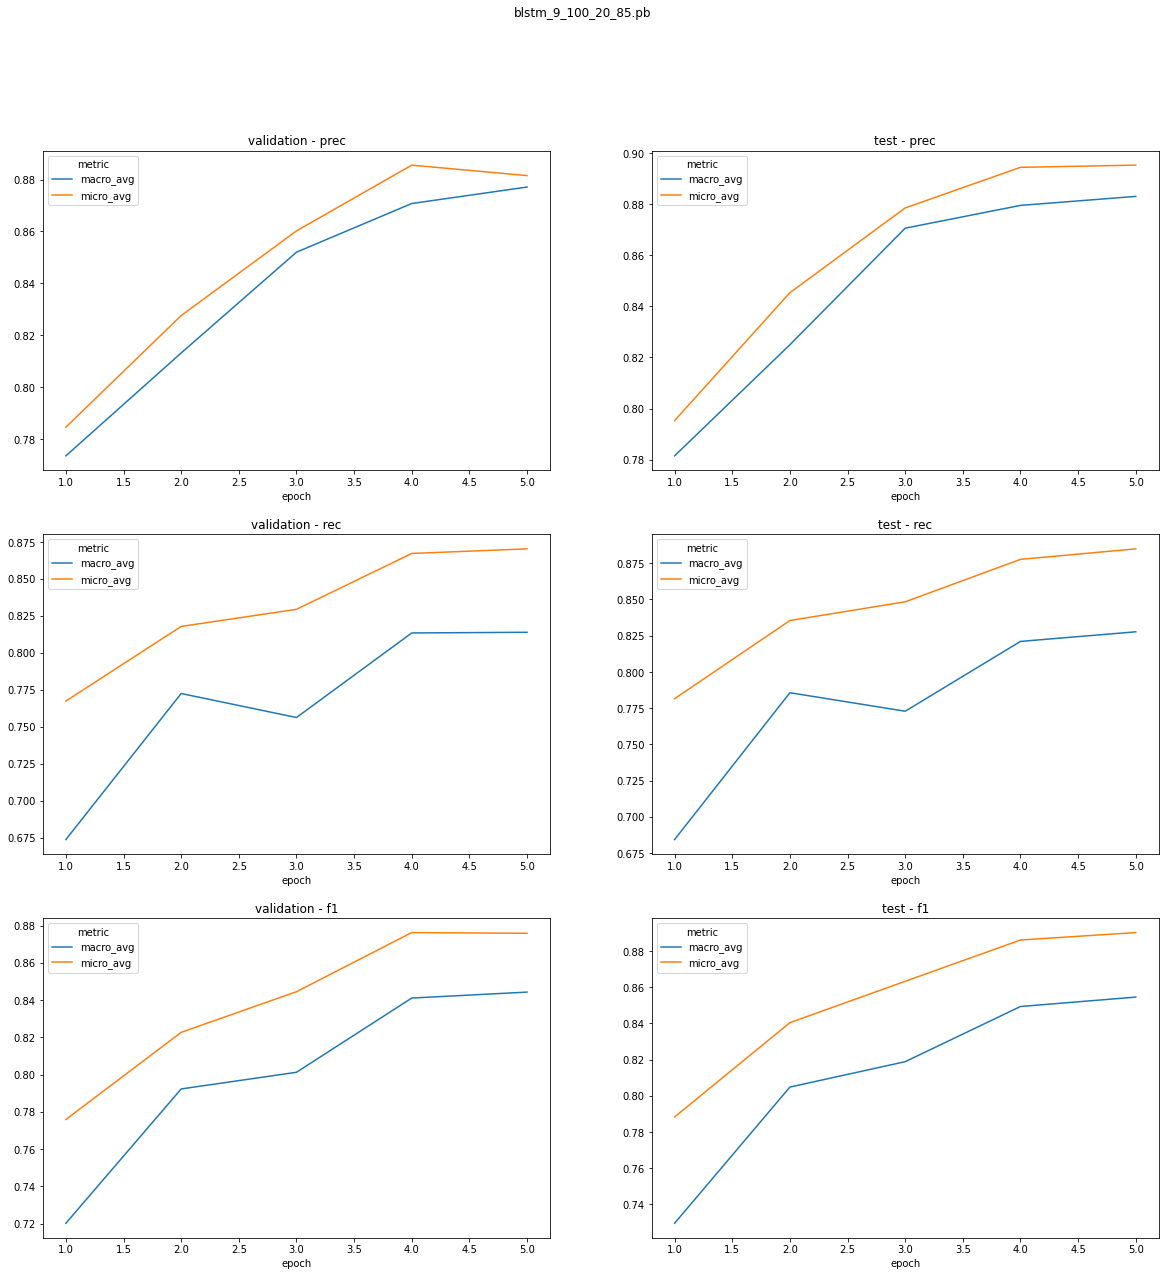

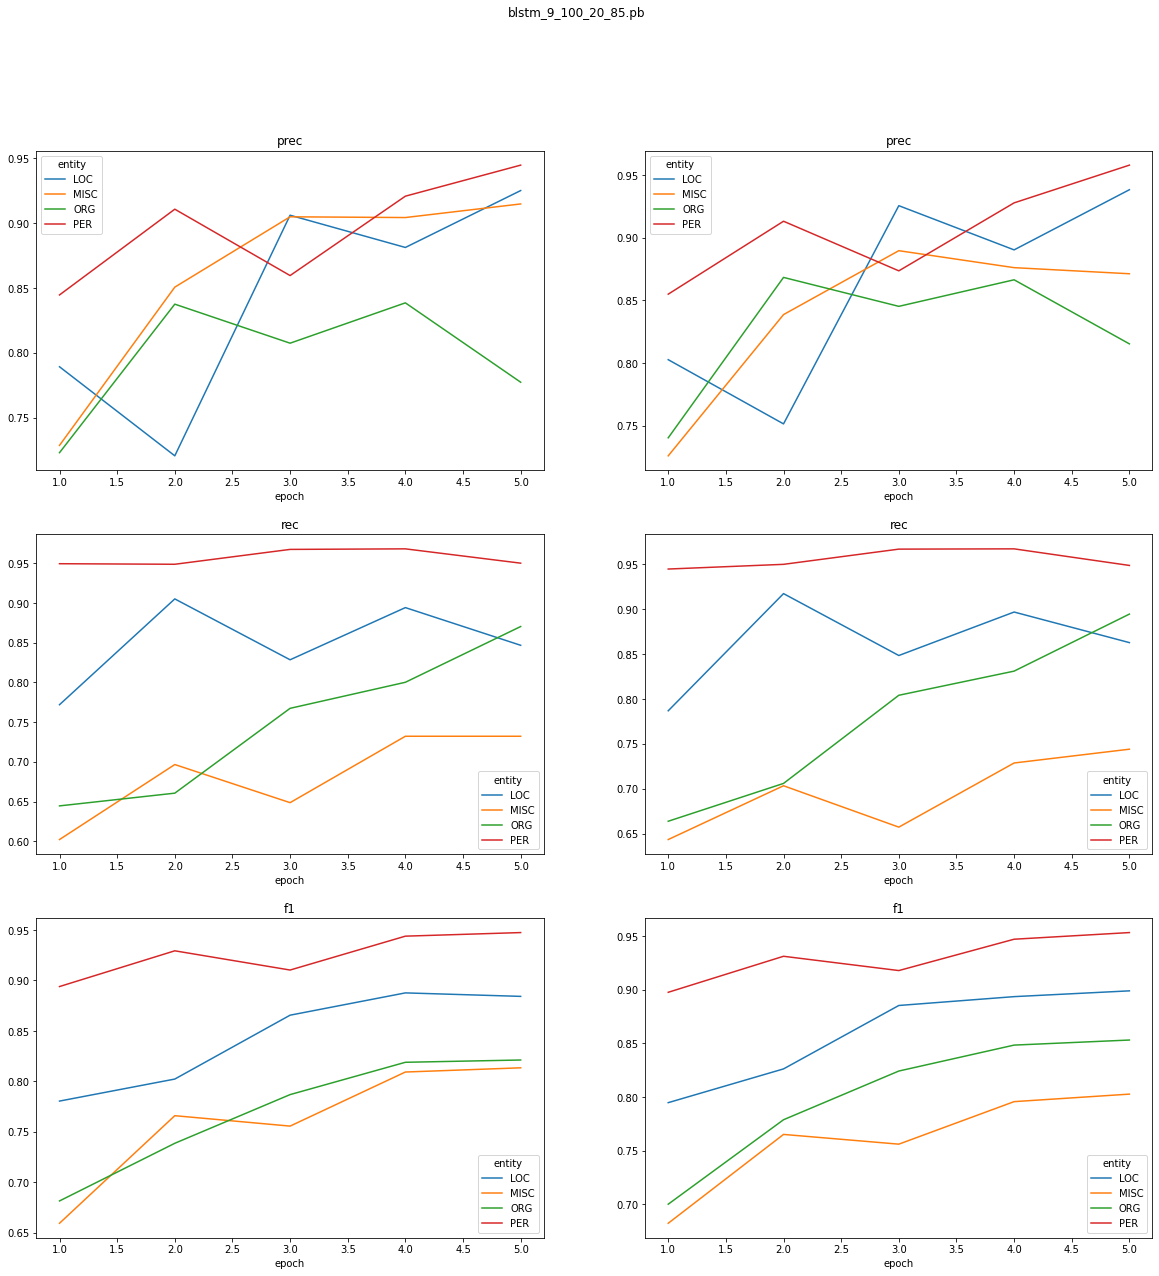

In [ ]:
ner_log_parser.get_charts('./ner_logs_best/'+log_files[0])

<br/>

#### **Plotting Loss**

Plotting the change in loss with the number of epochs may help determine the number of epochs required for training. 

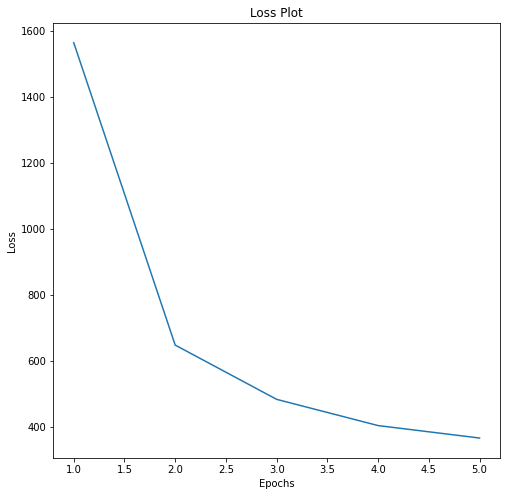

In [ ]:
ner_log_parser.loss_plot('./ner_logs_best/'+log_files[0])

The pattern in the above curve shows that, 20 will be a reasonable number of epochs for training. 

Until this number, the drop in loss is sharp, but after 20, the decrease in the loss value is much less. 

### 💾 **Saving the Trained Model**

It is possible to save the trained model locally, with the chance to load and get predictions later.

In [ ]:
ner_model.stages

[WORD_EMBEDDINGS_MODEL_48cffc8b9a76,
 TFNerDLGraphBuilderModel_84e645633ee1,
 NerDLModel_3d93eaa8e7f3]

In [ ]:
ner_model.stages[-1].write().overwrite().save('NER_glove_e5_b32')

In [ ]:
!ls -lt

total 5532
drwxr-xr-x 4 root root    4096 Jan 11 23:10 NER_glove_e5_b32
drwxr-xr-x 2 root root    4096 Jan 11 23:09 __pycache__
-rw-r--r-- 1 root root    3826 Jan 11 23:09 ner_log_parser.py
drwxr-xr-x 2 root root    4096 Jan 11 23:05 ner_logs_best
drwxr-xr-x 2 root root    4096 Jan 11 23:05 ner_graphs
drwxr-xr-x 2 root root    4096 Jan 11 23:05 ner_dl_test.parquet
drwxr-xr-x 2 root root    4096 Jan 11 23:00 ner_logs
-rw-r--r-- 1 root root    7431 Jan 11 23:00 conll_eval.py
-rw-r--r-- 1 root root  827443 Jan 11 22:57 eng.testa
-rw-r--r-- 1 root root 3283420 Jan 11 22:57 eng.train
drwxr-xr-x 1 root root    4096 Jan 10 14:33 sample_data
-rw-r--r-- 1 root root 1504408 Mar 16  2020 news_category_test.csv


### **📊 Getting Prediction from  the Trained Model**

After training, we saved the model; now we will load and use it for prediction.

In [ ]:
document = DocumentAssembler()\
            .setInputCol("text")\
            .setOutputCol("document")

sentence = SentenceDetector()\
            .setInputCols(['document'])\
            .setOutputCol('sentence')

token = Tokenizer()\
            .setInputCols(['sentence'])\
            .setOutputCol('token')

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
            .setInputCols(["document", "token"])\
            .setOutputCol("embeddings")
  
loaded_ner_model = NerDLModel.load("NER_glove_e5_b32")\
            .setInputCols(["sentence", "token", "embeddings"])\
            .setOutputCol("ner")

converter = NerConverter()\
            .setInputCols(["document", "token", "ner"])\
            .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        glove_embeddings,
        loaded_ner_model,
        converter
        ])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

In [ ]:
text = "Peter Parker is a nice guy and lives in New York."

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+-------------------------------------------------+
|text                                             |
+-------------------------------------------------+
|Peter Parker is a nice guy and lives in New York.|
+-------------------------------------------------+



#### **♻️ Transform & Get Predictions**

In [ ]:
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip(preds.ner_span.result,
                                    preds.ner_span.metadata)).alias("entities")) \
      .select(F.expr("entities['0']").alias("chunk"),
              F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+------------+------+
|chunk       |entity|
+------------+------+
|Peter Parker|PER   |
|New York    |LOC   |
+------------+------+



### **🔦 Use Light Pipeline**

In [ ]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [ ]:
text = "Peter Parker is a nice guy and lives in New York."

result = light_model.annotate(text)

list(zip(result['token'], result['ner']))

[('Peter', 'B-PER'),
 ('Parker', 'I-PER'),
 ('is', 'O'),
 ('a', 'O'),
 ('nice', 'O'),
 ('guy', 'O'),
 ('and', 'O'),
 ('lives', 'O'),
 ('in', 'O'),
 ('New', 'B-LOC'),
 ('York', 'I-LOC'),
 ('.', 'O')]

In [ ]:
result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

,sent_id,token,start,end,ner
0,0,Peter,0,4,B-PER
1,0,Parker,6,11,I-PER
2,0,is,13,14,O
3,0,a,16,16,O
4,0,nice,18,21,O
5,0,guy,23,25,O
6,0,and,27,29,O
7,0,lives,31,35,O
8,0,in,37,38,O
9,0,New,40,42,B-LOC
